# Initia Part (set-uuup)

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

# shared path to drive
SHARED_PATH = "/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

# direct path to drive
DIRECT_PATH = "/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Mounted at /content/drive


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = (
    SHARED_PATH
    if os.path.exists(SHARED_PATH)
    else DIRECT_PATH
    if os.path.exists(DIRECT_PATH)
    else None
)

DATA_PATH = ""
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj2_Heritage_places_in_CGR_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
RUN_THIS_all_in_one_parameter_changable.ipynb
Data
old_experiments
expr2_effnet.ipynb
expr1_resnet18.ipynb
training_images
validate_images
data.csv
maximize_dataset_make_csv_data.ipynb


##  Setup Device & Random State

In [ ]:
import torch
import random
import numpy as np

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# define the random seed
SEED = 2025

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

cuda


## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]
standev = [0.229, 0.224, 0.225]
px = 256

train_transform = transforms.Compose(
    [
        transforms.Resize((px, px)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(15, fill=10),  # Increased rotation degrees
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # transforms.RandomVerticalFlip(), # Uncomment if vertical flips are appropriate
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean), std=(standev)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((px, px)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mean), std=(standev)),
    ]
)

print(train_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=10)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Define data path

In [ ]:
train_path = DATA_PATH + "/training_images"
test_path = DATA_PATH + "/validate_images"

## Load dataset with Torch

In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
    root=DATA_PATH + "/training_images", transform=train_transform
)
test_dataset = ImageFolder(
    root=DATA_PATH + "/validate_images", transform=test_transform
)

CLASSES = train_dataset.classes
print(CLASSES)

print(train_dataset)
print(test_dataset)

['charch', 'clock_tower', 'jora_ghat', 'mondir', 'musium', 'patalbari']
Dataset ImageFolder
    Number of datapoints: 309
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/training_images
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=10)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 15
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_class

In [ ]:
print(train_dataset.class_to_idx)
print(len(train_dataset.class_to_idx))

{'charch': 0, 'clock_tower': 1, 'jora_ghat': 2, 'mondir': 3, 'musium': 4, 'patalbari': 5}
6


## Class definition

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


# Define the BuildingClassifier class
class BuildingClassifier:
    """
    A class to classify buildings and their facades using a given model.
    """

    # Initialize the classifier with model, loss functions, optimizer, and data parameters
    def __init__(
        self,
        model,
        optimizer,
        batch_size,
        loss_fn=nn.CrossEntropyLoss(),
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        categories=train_dataset.classes,
        device=DEVICE,
    ):
        """
        Initializes the BuildingClassifier.
        Args:
            model (torch.nn.Module): The neural network model to use for classification.
            building_loss_fn (torch.nn.Module): The loss function for building classification.
            facade_loss_fn (torch.nn.Module): The loss function for facade classification.
            optimizer (torch.optim.Optimizer): The optimizer for model training.
            learning_rate (float): The learning rate for the optimizer.
            batch_size (int): The batch size for data loaders.
            train_dataset (torch.utils.data.Dataset): The training dataset.
            test_dataset (torch.utils.data.Dataset): The testing dataset.
            categories (list): A list of building categories.
            device (torch.device): The device (CPU/GPU) to train the model on.
        """
        self.model = model.to(device)  # Move model to the specified device (CPU/GPU)
        self.loss_fn = loss_fn  # Loss function for building classification
        self.optimizer = optimizer  # Optimizer for model training
        self.batch_size = batch_size  # Batch size for data loaders
        self.train_dataset = train_dataset  # Training dataset
        self.test_dataset = test_dataset  # Testing dataset
        self.categories = categories  # List of building categories
        self.device = device  # Device to train the model on
        self.learning_rate = self.optimizer.param_groups[0][
            "lr"
        ]  # Learning rate for the optimizer

        # Create DataLoaders for training and testing
        # (num worker remove consistent results of each run)
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )  # , num_workers=2)
        self.test_loader = DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False
        )  # , num_workers=2)

    ############################################################################
    # Train the model for a specified number of epochs
    def train(self, n_epochs=10, output_logging=True):
        loss_graph_list, accy_list, valid_loss_list = (
            [],
            [],
            [],
        )  # Lists to store training metrics
        print(
            f"Starting training with Learning Rate: {self.learning_rate}, Batch Size: {self.batch_size}, Epochs: {n_epochs}, Device: {self.device}"
        )

        for epoch in tqdm(range(n_epochs)):
            self.model.train()  # Set the model to training mode
            training_loss = []  # List to store loss for the current epoch

            # Iterate over the training data
            for i_image, i_label in self.train_loader:
                i_image = i_image.to(self.device)  # Move image to device
                i_label = i_label.to(self.device)  # Move label to device

                self.optimizer.zero_grad()  # Zero the gradients

                output = self.model(i_image)  # Get model outputs
                loss = self.loss_fn(output, i_label)  # Calculate loss

                loss.backward()  # Backpropagate
                self.optimizer.step()  # Update the model's weights using the optimizer

                training_loss.append(loss.item())  # Append loss to list

            avg_training_loss = np.mean(training_loss)
            loss_graph_list.append(avg_training_loss)  # Store average training loss

            accy, current_valid_loss = self.evaluate(output_logging=False)
            valid_loss_list.append(current_valid_loss)  # Store validation loss
            accy_list.append(accy)  # Store accuracy

            if output_logging:
                print(
                    f" Training loss: {avg_training_loss:.4f} --Validation Loss: {current_valid_loss:.4f} --Predict Accuracy: {accy:.2f}%"
                )

        print("Training done.....................")
        return loss_graph_list, valid_loss_list, accy_list  # Return training metrics

    ############################################################################
    # Evaluate the model on the test set
    def evaluate(self, output_logging=True, disp_confusion_matrix=False):
        self.model.eval()  # Set the model to evaluation mode
        pred_correctly = 0  # Counter for correctly predicted samples
        total = 0  # Counter for total samples
        actual_labels = []  # List to store actual labels
        predicted_labels = []  # List to store predicted labels
        validation_loss = []  # List to store validation loss

        with torch.no_grad():  # Disable gradient calculation
            for i_image, i_label in self.test_loader:
                i_image = i_image.to(self.device)  # Move image to device
                i_label = i_label.to(self.device)  # Move label to device

                total += i_label.size(0)  # Increment total samples
                output = self.model(i_image)  # Get model outputs

                loss = self.loss_fn(output, i_label)  # Calculate building loss
                validation_loss.append(loss.item())  # Append loss to list

                _, predicted = torch.max(
                    output.data, 1
                )  # Get predicted class for building
                pred_correctly += (
                    (predicted == i_label).sum().item()
                )  # Count correct predictions

                actual_labels.extend(i_label.cpu().numpy())  # Store actual labels
                predicted_labels.extend(
                    predicted.cpu().numpy()
                )  # Store predicted labels

        accuracy = 100.0 * pred_correctly / total  # Calculate accuracy
        average_validation_loss = np.mean(
            validation_loss
        )  # Calculate average validation loss

        if output_logging:
            print(f" --Validation loss:- {average_validation_loss}", end="")
            print(
                f" --Testing....got-({pred_correctly}/{total})-correctly-->>accuracy=({accuracy:.2f}%)"
            )

        # Display confusion matrix if requested
        if disp_confusion_matrix:
            display_labels_list = [str(label) for label in self.categories]
            ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix(actual_labels, predicted_labels),
                display_labels=display_labels_list,
            ).plot()
            plt.xticks(rotation=90)
            plt.show()

        return accuracy, average_validation_loss  # Return accuracy and validation loss

    ############################################################################
    # Classify a single image
    def classify_image(self, img_path, img_transform):
        """
        Classifies a single image.
        Args:
            img_path (str): The path to the image.
            img_transform (callable): The image transform to apply.
        """
        self.model.eval()  # Set the model to evaluation mode
        input_img = Image.open(DATA_PATH + img_path)  # Load the image

        plt.figure(figsize=(10, 10), dpi=30)  # Create a figure for plotting
        plt.imshow(input_img)  # Display the image
        plt.axis("off")  # Turn off the axis
        plt.show()  # Show the plot

        img_tensor = (
            img_transform(input_img).unsqueeze(0).to(self.device)
        )  # Transform and prepare the image tensor
        with torch.no_grad():  # Disable gradient calculation
            output = self.model(img_tensor)  # Get model output
            probabilities1 = torch.nn.functional.softmax(
                output[0], dim=1
            )  # Calculate probabilities for building classes
            print(probabilities1)
            _, predicted_class_index = torch.max(
                probabilities1, 1
            )  # Get predicted building class index
            predicted_class = self.categories[
                predicted_class_index.item()
            ]  # Get predicted building class name
            print(f"Predicted class: {predicted_class}")  # Print predictions

## Plotting Training Results

In [ ]:
import matplotlib.pyplot as plt


def ploting(ax, arr, color, lname, ylabel="loss", xlabel="epoch"):
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)), arr, color=color)
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xlabel(xlabel)


def plot_classifier_results(train_loss, valid_loss, accy, classifier_name):
    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=90)
    ax2 = ax1.twinx()

    ploting(ax1, valid_loss, color="blue", lname=f"Validation Loss")
    ploting(ax1, train_loss, color="red", lname=f"Training Loss")
    ploting(
        ax2, accy, color="green", lname=f"Test Accuracy (%) ", ylabel="Accuracy (%)"
    )

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + handles2, labels1 + labels2, loc="lower left")

    plt.title(
        f"Training Loss, Validation Loss, and Test Accuracy per Epoch ({classifier_name})"
    )
    plt.tight_layout()
    plt.show()

## Modify the last layer





In [ ]:
def modify_last_layer(model, layer_type, pretrained, categories=train_dataset.classes):
    model._is_pretrained_backbone = pretrained
    # Assuming the last layer is named 'fc' as in many torchvision models
    last_layer_in = model.fc.in_features
    no_of_classes = len(categories)
    new_mid_layer_out = 256  # You can adjust this based on your needs

    if layer_type == "linear":
        print(f"convert from {last_layer_in} to-> {no_of_classes} output")
        model.fc = nn.Linear(last_layer_in, no_of_classes)
    elif layer_type == "sequential":
        print(
            f"convert from {last_layer_in} to-> {new_mid_layer_out} to-> {no_of_classes} output"
        )
        model.fc = nn.Sequential(
            torch.nn.Linear(in_features=last_layer_in, out_features=new_mid_layer_out),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(
                in_features=new_mid_layer_out,
                out_features=no_of_classes,
            ),
            # torch.nn.Softmax(dim=1), handels by crossentropyloss()
        )

    if pretrained:
        model = fc_weight_bias_init(model)
    else:
        model = all_weight_bias_init(model)
    return model

In [ ]:
import torch.nn.init as init


def fc_weight_bias_init(model):
    for module in model.fc.modules():
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(
                module.weight,
                a=0,
                mode="fan_out",
                nonlinearity="relu",
            )
            if module.bias is not None:
                fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / (fan_out) ** 0.5
                init.normal_(module.bias, -bound, bound)
    return model


def all_weight_bias_init(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(
                module.weight,
                a=0,
                mode="fan_out",
                nonlinearity="relu",
            )
            if module.bias is not None:
                fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / (fan_out) ** 0.5
                init.normal_(module.bias, -bound, bound)
    return model

In [ ]:
# Resets the weights of the entire model instance using the custom init_weights function.
# def reset_model(model):
#     if model._is_pretrained_backbone:
#         # model.apply(fc_weight_bias_init)
#         model=fc_weight_bias_init(model)
#         print('reset last')
#     else:
#         # model.apply(all_weight_bias_init)
#         model=all_weight_bias_init(model)
#         print('reset all')
#     return model

#### not works ####

# Main part

## Create instances and calsify

In [ ]:
import torchvision.models as models

### Classifier 1 Last layer linear

In [ ]:
model_1 = models.resnet18(weights=None)  # weights=None means pretrained=False

classifier1 = BuildingClassifier(
    model=modify_last_layer(model_1, layer_type="linear", pretrained=False),
    optimizer=optim.Adam(model_1.parameters(), lr=0.001),
    batch_size=16,
)

# change output_logging=True to print output of each iteration
train_loss1, valid_loss1, accy1 = classifier1.train(n_epochs=15, output_logging=True)

convert from 512 to-> 6 output
Starting training with Learning Rate: 0.001, Batch Size: 16, Epochs: 15, Device: cuda


  7%|▋         | 1/15 [02:46<38:48, 166.35s/it]

 Training loss: 14.7108 --Validation Loss: 51.0733 --Predict Accuracy: 26.67%


 13%|█▎        | 2/15 [02:58<16:25, 75.83s/it] 

 Training loss: 4.9874 --Validation Loss: 12.7801 --Predict Accuracy: 46.67%


 20%|██        | 3/15 [03:11<09:21, 46.82s/it]

 Training loss: 2.9942 --Validation Loss: 9.2339 --Predict Accuracy: 33.33%


 27%|██▋       | 4/15 [03:23<06:05, 33.22s/it]

 Training loss: 2.0152 --Validation Loss: 6.8100 --Predict Accuracy: 53.33%


 33%|███▎      | 5/15 [03:35<04:16, 25.64s/it]

 Training loss: 0.8234 --Validation Loss: 5.9582 --Predict Accuracy: 53.33%


 40%|████      | 6/15 [03:48<03:10, 21.14s/it]

 Training loss: 0.8211 --Validation Loss: 4.3138 --Predict Accuracy: 40.00%


 47%|████▋     | 7/15 [04:00<02:26, 18.29s/it]

 Training loss: 0.6726 --Validation Loss: 4.7979 --Predict Accuracy: 60.00%


 53%|█████▎    | 8/15 [04:12<01:54, 16.39s/it]

 Training loss: 0.3691 --Validation Loss: 5.2004 --Predict Accuracy: 66.67%


 60%|██████    | 9/15 [04:25<01:30, 15.14s/it]

 Training loss: 0.4893 --Validation Loss: 6.3143 --Predict Accuracy: 60.00%


 67%|██████▋   | 10/15 [04:37<01:11, 14.27s/it]

 Training loss: 0.6357 --Validation Loss: 6.0516 --Predict Accuracy: 60.00%


 73%|███████▎  | 11/15 [04:49<00:54, 13.65s/it]

 Training loss: 0.8863 --Validation Loss: 5.1542 --Predict Accuracy: 60.00%


 80%|████████  | 12/15 [05:01<00:39, 13.17s/it]

 Training loss: 1.6933 --Validation Loss: 11.3962 --Predict Accuracy: 46.67%


 87%|████████▋ | 13/15 [05:13<00:25, 12.83s/it]

 Training loss: 0.6469 --Validation Loss: 6.4286 --Predict Accuracy: 60.00%


 93%|█████████▎| 14/15 [05:26<00:12, 12.65s/it]

 Training loss: 0.1958 --Validation Loss: 4.6394 --Predict Accuracy: 66.67%


100%|██████████| 15/15 [05:38<00:00, 22.57s/it]

 Training loss: 0.1925 --Validation Loss: 4.5370 --Predict Accuracy: 73.33%
Training done.....................


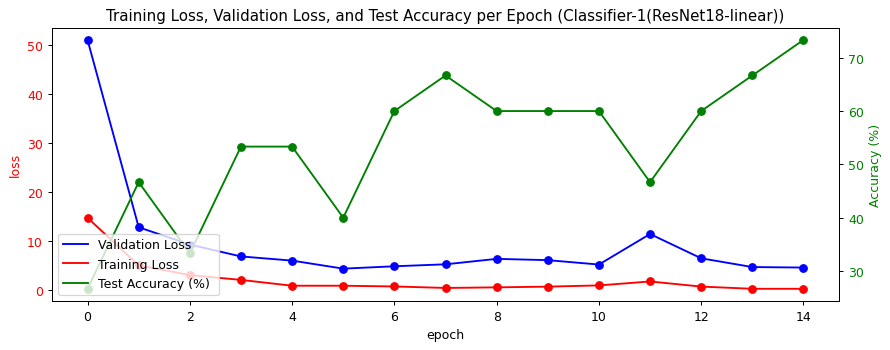

 --Validation loss:- 4.536957740783691 --Testing....got-(11/15)-correctly-->>accuracy=(73.33%)


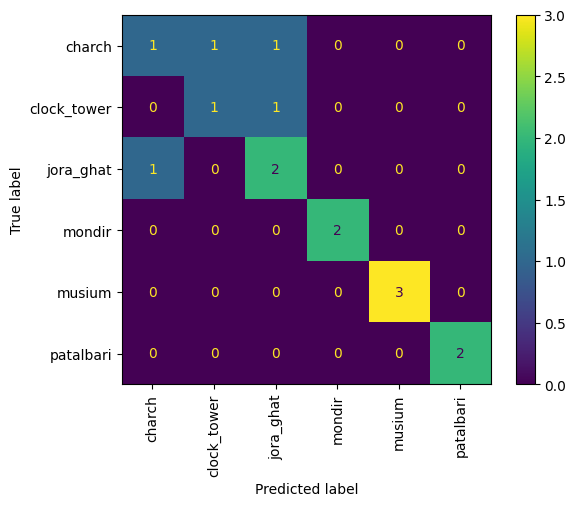

(73.33333333333333, np.float64(4.536957740783691))

In [ ]:
plot_classifier_results(
    train_loss1, valid_loss1, accy1, "Classifier-1(ResNet18-linear)"
)
classifier1.evaluate(disp_confusion_matrix=True)

### Classifier 21 last layer sequential

In [ ]:
model2 = models.resnet18(weights=None)
model2 = modify_last_layer(model2, layer_type="sequential", pretrained=False)

classifier21 = BuildingClassifier(
    model=model2,
    optimizer=optim.Adam(model2.parameters(), lr=0.001),
    batch_size=16,
)

# change output_logging=True to print output of each iteration
train_loss21, valid_loss21, accy21 = classifier21.train(
    n_epochs=15, output_logging=True
)

convert from 512 to-> 256 to-> 6 output
Starting training with Learning Rate: 0.001, Batch Size: 16, Epochs: 15, Device: cuda


  7%|▋         | 1/15 [00:12<02:51, 12.24s/it]

 Training loss: 14.6311 --Validation Loss: 1617.0176 --Predict Accuracy: 20.00%


 13%|█▎        | 2/15 [00:24<02:39, 12.30s/it]

 Training loss: 6.6986 --Validation Loss: 21.0740 --Predict Accuracy: 40.00%


 20%|██        | 3/15 [00:37<02:28, 12.38s/it]

 Training loss: 4.5129 --Validation Loss: 11.1039 --Predict Accuracy: 13.33%


 27%|██▋       | 4/15 [00:49<02:16, 12.38s/it]

 Training loss: 2.5728 --Validation Loss: 15.7349 --Predict Accuracy: 26.67%


 33%|███▎      | 5/15 [01:01<02:03, 12.39s/it]

 Training loss: 1.4296 --Validation Loss: 3.9068 --Predict Accuracy: 60.00%


 40%|████      | 6/15 [01:14<01:51, 12.39s/it]

 Training loss: 1.0837 --Validation Loss: 4.4282 --Predict Accuracy: 33.33%


 47%|████▋     | 7/15 [01:26<01:39, 12.38s/it]

 Training loss: 0.8247 --Validation Loss: 3.2311 --Predict Accuracy: 46.67%


 53%|█████▎    | 8/15 [01:39<01:26, 12.40s/it]

 Training loss: 0.8935 --Validation Loss: 2.6553 --Predict Accuracy: 73.33%


 60%|██████    | 9/15 [01:51<01:14, 12.39s/it]

 Training loss: 0.9604 --Validation Loss: 1.9077 --Predict Accuracy: 66.67%


 67%|██████▋   | 10/15 [02:03<01:01, 12.39s/it]

 Training loss: 0.8152 --Validation Loss: 2.6183 --Predict Accuracy: 80.00%


 73%|███████▎  | 11/15 [02:16<00:49, 12.38s/it]

 Training loss: 0.7004 --Validation Loss: 1.6947 --Predict Accuracy: 46.67%


 80%|████████  | 12/15 [02:28<00:37, 12.36s/it]

 Training loss: 0.3593 --Validation Loss: 1.3107 --Predict Accuracy: 60.00%


 87%|████████▋ | 13/15 [02:40<00:24, 12.26s/it]

 Training loss: 0.4198 --Validation Loss: 2.0779 --Predict Accuracy: 60.00%


 93%|█████████▎| 14/15 [02:52<00:12, 12.22s/it]

 Training loss: 0.4127 --Validation Loss: 1.3760 --Predict Accuracy: 80.00%


100%|██████████| 15/15 [03:04<00:00, 12.32s/it]

 Training loss: 0.3864 --Validation Loss: 1.4434 --Predict Accuracy: 73.33%
Training done.....................


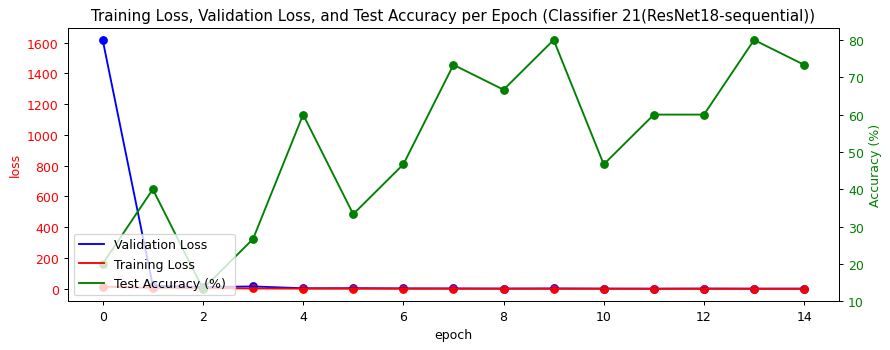

 --Validation loss:- 1.443368911743164 --Testing....got-(11/15)-correctly-->>accuracy=(73.33%)


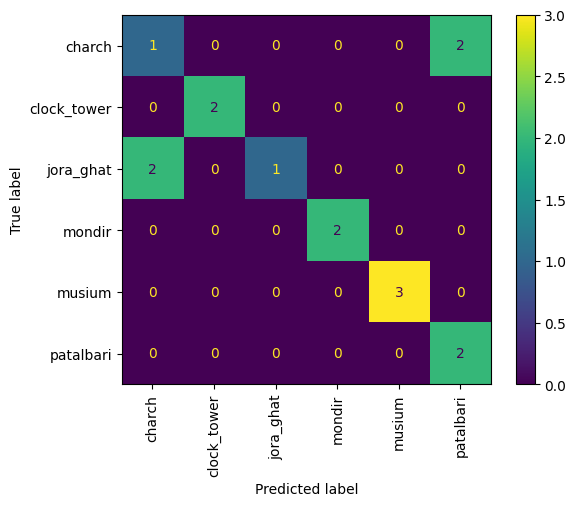

(73.33333333333333, np.float64(1.443368911743164))

In [ ]:
# plot results
plot_classifier_results(
    train_loss21, valid_loss21, accy21, "Classifier 21(ResNet18-sequential)"
)
classifier21.evaluate(disp_confusion_matrix=True)

### Classifier 22 last layer sequential

In [ ]:
model22 = models.resnet18(weights=None)
model22 = modify_last_layer(model22, layer_type="sequential", pretrained=False)

# Instance 2 with different parameters
classifier22 = BuildingClassifier(
    model=model22,
    optimizer=optim.Adam(model22.parameters(), lr=0.01),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
train_loss22, valid_loss22, accy22 = classifier22.train(
    n_epochs=10, output_logging=True
)

convert from 512 to-> 256 to-> 6 output
Starting training with Learning Rate: 0.01, Batch Size: 32, Epochs: 10, Device: cuda


 10%|█         | 1/10 [00:11<01:46, 11.82s/it]

 Training loss: 34.7260 --Validation Loss: 7344254.0000 --Predict Accuracy: 20.00%


 20%|██        | 2/10 [00:23<01:35, 11.89s/it]

 Training loss: 12.6822 --Validation Loss: 77208.7891 --Predict Accuracy: 20.00%


 30%|███       | 3/10 [00:35<01:23, 11.93s/it]

 Training loss: 4.7574 --Validation Loss: 849.5089 --Predict Accuracy: 26.67%


 40%|████      | 4/10 [00:47<01:11, 11.93s/it]

 Training loss: 2.9441 --Validation Loss: 187.4114 --Predict Accuracy: 20.00%


 50%|█████     | 5/10 [00:59<00:59, 11.93s/it]

 Training loss: 4.2322 --Validation Loss: 113.4259 --Predict Accuracy: 26.67%


 60%|██████    | 6/10 [01:11<00:47, 11.94s/it]

 Training loss: 2.5706 --Validation Loss: 1.8604 --Predict Accuracy: 26.67%


 70%|███████   | 7/10 [01:23<00:35, 11.93s/it]

 Training loss: 2.9526 --Validation Loss: 1.8240 --Predict Accuracy: 13.33%


 80%|████████  | 8/10 [01:35<00:23, 12.00s/it]

 Training loss: 2.0272 --Validation Loss: 1.7905 --Predict Accuracy: 20.00%


 90%|█████████ | 9/10 [01:47<00:11, 11.99s/it]

 Training loss: 2.0883 --Validation Loss: 1.8490 --Predict Accuracy: 20.00%


100%|██████████| 10/10 [01:59<00:00, 11.91s/it]

 Training loss: 2.0427 --Validation Loss: 1.7360 --Predict Accuracy: 26.67%
Training done.....................


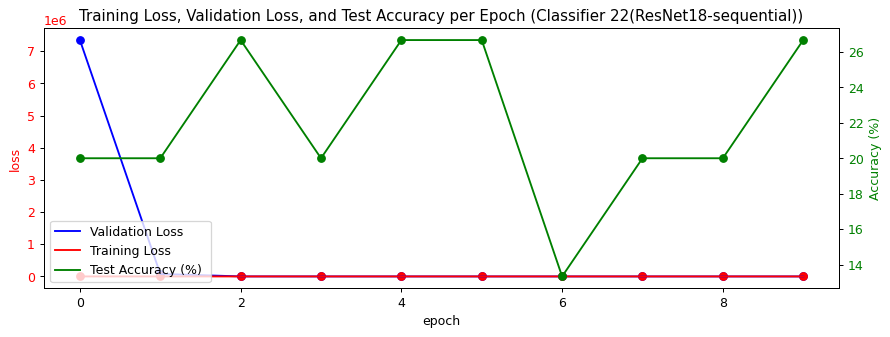

 --Validation loss:- 1.7359540462493896 --Testing....got-(4/15)-correctly-->>accuracy=(26.67%)


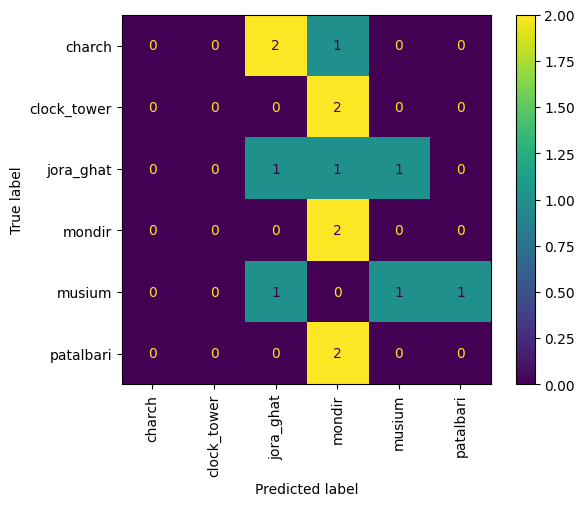

(26.666666666666668, np.float64(1.7359540462493896))

In [ ]:
# plot results
plot_classifier_results(
    train_loss22, valid_loss22, accy22, "Classifier 22(ResNet18-sequential)"
)
classifier22.evaluate(disp_confusion_matrix=True)

### Higher epoches test 1


In [ ]:
model_A = models.resnet18(weights=None)
model_A = modify_last_layer(model_A, layer_type="sequential", pretrained=False)

# Instance 2 with different parameters
classifier22 = BuildingClassifier(
    model=model_A,
    optimizer=optim.Adam(model_A.parameters(), lr=0.0001),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
train_loss22, valid_loss22, accy22 = classifier22.train(
    n_epochs=100, output_logging=True
)

convert from 512 to-> 256 to-> 6 output
Starting training with Learning Rate: 0.0001, Batch Size: 32, Epochs: 100, Device: cuda


  1%|          | 1/100 [00:11<19:17, 11.69s/it]

 Training loss: 11.1266 --Validation Loss: 7.2145 --Predict Accuracy: 13.33%


  2%|▏         | 2/100 [00:23<19:08, 11.72s/it]

 Training loss: 5.3853 --Validation Loss: 9.2508 --Predict Accuracy: 20.00%


  3%|▎         | 3/100 [00:35<19:13, 11.89s/it]

 Training loss: 3.4715 --Validation Loss: 5.3069 --Predict Accuracy: 33.33%


  4%|▍         | 4/100 [00:47<19:05, 11.93s/it]

 Training loss: 2.3413 --Validation Loss: 7.4050 --Predict Accuracy: 20.00%


  5%|▌         | 5/100 [00:59<18:55, 11.95s/it]

 Training loss: 1.9933 --Validation Loss: 8.8040 --Predict Accuracy: 40.00%


  6%|▌         | 6/100 [01:11<18:45, 11.97s/it]

 Training loss: 1.6581 --Validation Loss: 5.2025 --Predict Accuracy: 26.67%


  7%|▋         | 7/100 [01:23<18:34, 11.98s/it]

 Training loss: 1.3000 --Validation Loss: 7.6243 --Predict Accuracy: 33.33%


  8%|▊         | 8/100 [01:35<18:24, 12.01s/it]

 Training loss: 0.7942 --Validation Loss: 7.9746 --Predict Accuracy: 26.67%


  9%|▉         | 9/100 [01:47<18:12, 12.00s/it]

 Training loss: 0.6115 --Validation Loss: 5.8254 --Predict Accuracy: 46.67%


 10%|█         | 10/100 [01:59<18:07, 12.08s/it]

 Training loss: 0.5293 --Validation Loss: 7.8189 --Predict Accuracy: 60.00%


 11%|█         | 11/100 [02:11<17:49, 12.02s/it]

 Training loss: 0.4432 --Validation Loss: 6.4627 --Predict Accuracy: 60.00%


 12%|█▏        | 12/100 [02:23<17:29, 11.92s/it]

 Training loss: 0.4643 --Validation Loss: 3.8846 --Predict Accuracy: 53.33%


 13%|█▎        | 13/100 [02:35<17:13, 11.87s/it]

 Training loss: 0.4098 --Validation Loss: 7.2174 --Predict Accuracy: 46.67%


 14%|█▍        | 14/100 [02:47<17:05, 11.93s/it]

 Training loss: 0.4643 --Validation Loss: 6.1215 --Predict Accuracy: 46.67%


 15%|█▌        | 15/100 [02:59<17:01, 12.02s/it]

 Training loss: 0.5464 --Validation Loss: 5.1143 --Predict Accuracy: 53.33%


 16%|█▌        | 16/100 [03:11<16:49, 12.02s/it]

 Training loss: 0.3058 --Validation Loss: 6.6920 --Predict Accuracy: 73.33%


 17%|█▋        | 17/100 [03:23<16:35, 11.99s/it]

 Training loss: 0.6240 --Validation Loss: 6.6128 --Predict Accuracy: 60.00%


 18%|█▊        | 18/100 [03:35<16:23, 11.99s/it]

 Training loss: 0.2945 --Validation Loss: 6.9169 --Predict Accuracy: 60.00%


 19%|█▉        | 19/100 [03:47<16:12, 12.01s/it]

 Training loss: 0.2227 --Validation Loss: 5.2988 --Predict Accuracy: 60.00%


 20%|██        | 20/100 [03:59<16:00, 12.01s/it]

 Training loss: 0.1683 --Validation Loss: 5.1207 --Predict Accuracy: 53.33%


 21%|██        | 21/100 [04:11<15:50, 12.03s/it]

 Training loss: 0.1967 --Validation Loss: 6.1446 --Predict Accuracy: 46.67%


 22%|██▏       | 22/100 [04:23<15:29, 11.91s/it]

 Training loss: 0.1203 --Validation Loss: 4.8293 --Predict Accuracy: 53.33%


 23%|██▎       | 23/100 [04:34<15:15, 11.89s/it]

 Training loss: 0.0839 --Validation Loss: 4.9260 --Predict Accuracy: 60.00%


 24%|██▍       | 24/100 [04:46<15:02, 11.88s/it]

 Training loss: 0.1964 --Validation Loss: 5.2179 --Predict Accuracy: 66.67%


 25%|██▌       | 25/100 [04:58<14:52, 11.90s/it]

 Training loss: 0.2426 --Validation Loss: 5.8790 --Predict Accuracy: 80.00%


 26%|██▌       | 26/100 [05:10<14:42, 11.93s/it]

 Training loss: 0.1902 --Validation Loss: 4.6375 --Predict Accuracy: 60.00%


 27%|██▋       | 27/100 [05:22<14:32, 11.95s/it]

 Training loss: 0.0331 --Validation Loss: 6.3065 --Predict Accuracy: 53.33%


 28%|██▊       | 28/100 [05:34<14:22, 11.98s/it]

 Training loss: 0.0919 --Validation Loss: 3.7154 --Predict Accuracy: 60.00%


 29%|██▉       | 29/100 [05:46<14:11, 11.99s/it]

 Training loss: 0.0420 --Validation Loss: 5.7196 --Predict Accuracy: 60.00%


 30%|███       | 30/100 [05:58<13:59, 11.99s/it]

 Training loss: 0.0363 --Validation Loss: 5.8781 --Predict Accuracy: 60.00%


 31%|███       | 31/100 [06:10<13:46, 11.98s/it]

 Training loss: 0.0381 --Validation Loss: 5.6407 --Predict Accuracy: 53.33%


 32%|███▏      | 32/100 [06:22<13:35, 11.99s/it]

 Training loss: 0.0490 --Validation Loss: 2.7795 --Predict Accuracy: 66.67%


 33%|███▎      | 33/100 [06:34<13:17, 11.90s/it]

 Training loss: 0.1842 --Validation Loss: 5.9044 --Predict Accuracy: 66.67%


 34%|███▍      | 34/100 [06:46<13:01, 11.85s/it]

 Training loss: 0.1233 --Validation Loss: 6.0110 --Predict Accuracy: 53.33%


 35%|███▌      | 35/100 [06:58<12:51, 11.87s/it]

 Training loss: 0.0564 --Validation Loss: 6.7743 --Predict Accuracy: 53.33%


 36%|███▌      | 36/100 [07:10<12:43, 11.94s/it]

 Training loss: 0.2046 --Validation Loss: 5.3961 --Predict Accuracy: 53.33%


 37%|███▋      | 37/100 [07:22<12:33, 11.96s/it]

 Training loss: 0.1336 --Validation Loss: 3.6520 --Predict Accuracy: 73.33%


 38%|███▊      | 38/100 [07:37<13:30, 13.07s/it]

 Training loss: 0.0499 --Validation Loss: 3.4439 --Predict Accuracy: 66.67%


 39%|███▉      | 39/100 [07:53<14:05, 13.86s/it]

 Training loss: 0.1349 --Validation Loss: 5.7245 --Predict Accuracy: 66.67%


 40%|████      | 40/100 [08:05<13:13, 13.22s/it]

 Training loss: 0.1071 --Validation Loss: 3.9840 --Predict Accuracy: 60.00%


 41%|████      | 41/100 [08:17<12:39, 12.88s/it]

 Training loss: 0.0355 --Validation Loss: 3.9159 --Predict Accuracy: 86.67%


 42%|████▏     | 42/100 [08:29<12:13, 12.65s/it]

 Training loss: 0.2140 --Validation Loss: 4.7495 --Predict Accuracy: 73.33%


 43%|████▎     | 43/100 [08:41<11:52, 12.49s/it]

 Training loss: 0.1008 --Validation Loss: 4.6684 --Predict Accuracy: 53.33%


 44%|████▍     | 44/100 [08:53<11:32, 12.36s/it]

 Training loss: 0.0820 --Validation Loss: 4.0220 --Predict Accuracy: 53.33%


 45%|████▌     | 45/100 [09:05<11:13, 12.25s/it]

 Training loss: 0.0637 --Validation Loss: 1.8497 --Predict Accuracy: 73.33%


 46%|████▌     | 46/100 [09:17<10:58, 12.19s/it]

 Training loss: 0.0218 --Validation Loss: 3.2527 --Predict Accuracy: 73.33%


 47%|████▋     | 47/100 [09:30<11:01, 12.49s/it]

 Training loss: 0.1277 --Validation Loss: 5.3672 --Predict Accuracy: 66.67%


 48%|████▊     | 48/100 [09:43<10:43, 12.37s/it]

 Training loss: 0.2392 --Validation Loss: 5.1049 --Predict Accuracy: 66.67%


 49%|████▉     | 49/100 [09:55<10:24, 12.25s/it]

 Training loss: 0.2972 --Validation Loss: 7.5382 --Predict Accuracy: 60.00%


 50%|█████     | 50/100 [10:06<10:05, 12.11s/it]

 Training loss: 0.2264 --Validation Loss: 3.4388 --Predict Accuracy: 73.33%


 51%|█████     | 51/100 [10:18<09:47, 12.00s/it]

 Training loss: 0.0823 --Validation Loss: 2.2617 --Predict Accuracy: 80.00%


 52%|█████▏    | 52/100 [10:30<09:34, 11.97s/it]

 Training loss: 0.1086 --Validation Loss: 4.0242 --Predict Accuracy: 66.67%


 53%|█████▎    | 53/100 [10:42<09:23, 11.98s/it]

 Training loss: 0.1222 --Validation Loss: 5.5528 --Predict Accuracy: 66.67%


 54%|█████▍    | 54/100 [10:54<09:11, 12.00s/it]

 Training loss: 0.0361 --Validation Loss: 4.0923 --Predict Accuracy: 73.33%


 55%|█████▌    | 55/100 [11:06<09:00, 12.01s/it]

 Training loss: 0.0520 --Validation Loss: 5.2949 --Predict Accuracy: 66.67%


 56%|█████▌    | 56/100 [11:18<08:48, 12.00s/it]

 Training loss: 0.0575 --Validation Loss: 5.1500 --Predict Accuracy: 60.00%


 57%|█████▋    | 57/100 [11:30<08:36, 12.02s/it]

 Training loss: 0.0733 --Validation Loss: 7.1374 --Predict Accuracy: 53.33%


 58%|█████▊    | 58/100 [11:42<08:26, 12.05s/it]

 Training loss: 0.1504 --Validation Loss: 6.8438 --Predict Accuracy: 66.67%


 59%|█████▉    | 59/100 [11:54<08:14, 12.05s/it]

 Training loss: 0.0801 --Validation Loss: 8.6723 --Predict Accuracy: 60.00%


 60%|██████    | 60/100 [12:06<08:01, 12.05s/it]

 Training loss: 0.0552 --Validation Loss: 7.1258 --Predict Accuracy: 60.00%


 61%|██████    | 61/100 [12:18<07:49, 12.04s/it]

 Training loss: 0.0193 --Validation Loss: 3.8400 --Predict Accuracy: 60.00%


 62%|██████▏   | 62/100 [12:30<07:34, 11.95s/it]

 Training loss: 0.0583 --Validation Loss: 2.8240 --Predict Accuracy: 73.33%


 63%|██████▎   | 63/100 [12:42<07:19, 11.88s/it]

 Training loss: 0.1171 --Validation Loss: 3.7918 --Predict Accuracy: 66.67%


 64%|██████▍   | 64/100 [12:54<07:10, 11.95s/it]

 Training loss: 0.0553 --Validation Loss: 8.1006 --Predict Accuracy: 66.67%


 65%|██████▌   | 65/100 [13:06<06:59, 11.97s/it]

 Training loss: 0.1129 --Validation Loss: 2.8340 --Predict Accuracy: 80.00%


 66%|██████▌   | 66/100 [13:18<06:48, 12.01s/it]

 Training loss: 0.1005 --Validation Loss: 5.6891 --Predict Accuracy: 73.33%


 67%|██████▋   | 67/100 [13:30<06:36, 12.03s/it]

 Training loss: 0.1544 --Validation Loss: 4.1098 --Predict Accuracy: 66.67%


 68%|██████▊   | 68/100 [13:42<06:24, 12.02s/it]

 Training loss: 0.0077 --Validation Loss: 4.0410 --Predict Accuracy: 73.33%


 69%|██████▉   | 69/100 [13:54<06:12, 12.02s/it]

 Training loss: 0.0511 --Validation Loss: 3.9953 --Predict Accuracy: 73.33%


 70%|███████   | 70/100 [14:06<06:00, 12.01s/it]

 Training loss: 0.0688 --Validation Loss: 3.2685 --Predict Accuracy: 73.33%


 71%|███████   | 71/100 [14:18<05:48, 12.01s/it]

 Training loss: 0.0858 --Validation Loss: 2.9503 --Predict Accuracy: 73.33%


 72%|███████▏  | 72/100 [14:30<05:36, 12.03s/it]

 Training loss: 0.0340 --Validation Loss: 4.1452 --Predict Accuracy: 66.67%


 73%|███████▎  | 73/100 [14:42<05:22, 11.94s/it]

 Training loss: 0.0001 --Validation Loss: 5.1419 --Predict Accuracy: 60.00%


 74%|███████▍  | 74/100 [14:54<05:10, 11.93s/it]

 Training loss: 0.0784 --Validation Loss: 4.2565 --Predict Accuracy: 60.00%


 75%|███████▌  | 75/100 [15:06<04:59, 11.97s/it]

 Training loss: 0.0076 --Validation Loss: 3.6707 --Predict Accuracy: 60.00%


 76%|███████▌  | 76/100 [15:18<04:47, 11.99s/it]

 Training loss: 0.0202 --Validation Loss: 3.6356 --Predict Accuracy: 60.00%


 77%|███████▋  | 77/100 [15:30<04:36, 12.04s/it]

 Training loss: 0.0087 --Validation Loss: 3.4246 --Predict Accuracy: 80.00%


 78%|███████▊  | 78/100 [15:42<04:25, 12.05s/it]

 Training loss: 0.0308 --Validation Loss: 3.9009 --Predict Accuracy: 73.33%


 79%|███████▉  | 79/100 [15:54<04:13, 12.05s/it]

 Training loss: 0.0653 --Validation Loss: 4.1257 --Predict Accuracy: 73.33%


 80%|████████  | 80/100 [16:06<04:00, 12.01s/it]

 Training loss: 0.0085 --Validation Loss: 5.7475 --Predict Accuracy: 66.67%


 81%|████████  | 81/100 [16:18<03:48, 12.03s/it]

 Training loss: 0.0193 --Validation Loss: 5.4542 --Predict Accuracy: 60.00%


 82%|████████▏ | 82/100 [16:30<03:36, 12.03s/it]

 Training loss: 0.0505 --Validation Loss: 4.6872 --Predict Accuracy: 53.33%


 83%|████████▎ | 83/100 [16:42<03:24, 12.01s/it]

 Training loss: 0.0031 --Validation Loss: 3.5564 --Predict Accuracy: 60.00%


 84%|████████▍ | 84/100 [16:54<03:10, 11.91s/it]

 Training loss: 0.0151 --Validation Loss: 2.8967 --Predict Accuracy: 73.33%


 85%|████████▌ | 85/100 [17:06<02:57, 11.85s/it]

 Training loss: 0.0133 --Validation Loss: 2.7923 --Predict Accuracy: 73.33%


 86%|████████▌ | 86/100 [17:18<02:46, 11.92s/it]

 Training loss: 0.0137 --Validation Loss: 3.1260 --Predict Accuracy: 73.33%


 87%|████████▋ | 87/100 [17:30<02:35, 11.98s/it]

 Training loss: 0.0360 --Validation Loss: 3.6597 --Predict Accuracy: 66.67%


 88%|████████▊ | 88/100 [17:42<02:25, 12.14s/it]

 Training loss: 0.0174 --Validation Loss: 4.9609 --Predict Accuracy: 66.67%


 89%|████████▉ | 89/100 [17:55<02:16, 12.43s/it]

 Training loss: 0.0136 --Validation Loss: 5.5829 --Predict Accuracy: 66.67%


 90%|█████████ | 90/100 [18:08<02:05, 12.53s/it]

 Training loss: 0.0263 --Validation Loss: 4.2831 --Predict Accuracy: 66.67%


 91%|█████████ | 91/100 [18:20<01:52, 12.46s/it]

 Training loss: 0.0246 --Validation Loss: 3.6273 --Predict Accuracy: 73.33%


 92%|█████████▏| 92/100 [18:33<01:38, 12.34s/it]

 Training loss: 0.0090 --Validation Loss: 3.1209 --Predict Accuracy: 66.67%


 93%|█████████▎| 93/100 [18:47<01:31, 13.12s/it]

 Training loss: 0.0365 --Validation Loss: 3.5292 --Predict Accuracy: 73.33%


 94%|█████████▍| 94/100 [19:00<01:18, 13.08s/it]

 Training loss: 0.0974 --Validation Loss: 4.3538 --Predict Accuracy: 73.33%


 95%|█████████▌| 95/100 [19:13<01:03, 12.79s/it]

 Training loss: 0.0140 --Validation Loss: 6.6693 --Predict Accuracy: 53.33%


 96%|█████████▌| 96/100 [19:25<00:50, 12.56s/it]

 Training loss: 0.0084 --Validation Loss: 5.9771 --Predict Accuracy: 60.00%


 97%|█████████▋| 97/100 [19:37<00:37, 12.43s/it]

 Training loss: 0.0553 --Validation Loss: 5.3637 --Predict Accuracy: 60.00%


 98%|█████████▊| 98/100 [19:50<00:25, 12.82s/it]

 Training loss: 0.0885 --Validation Loss: 9.8349 --Predict Accuracy: 60.00%


 99%|█████████▉| 99/100 [20:03<00:12, 12.62s/it]

 Training loss: 0.0929 --Validation Loss: 5.4805 --Predict Accuracy: 60.00%


100%|██████████| 100/100 [20:15<00:00, 12.15s/it]

 Training loss: 0.0927 --Validation Loss: 4.6911 --Predict Accuracy: 66.67%
Training done.....................


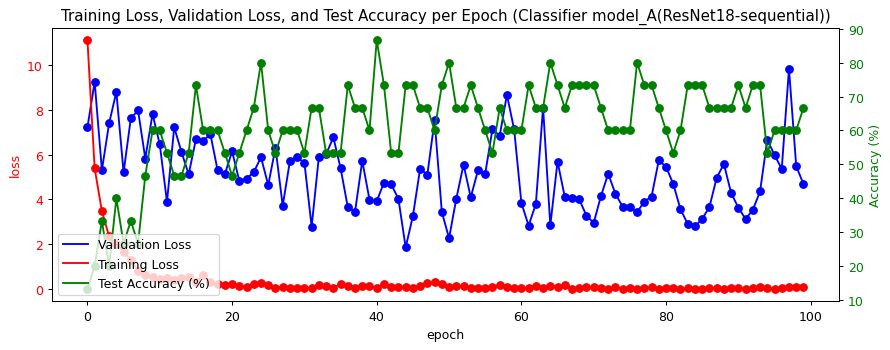

 --Validation loss:- 4.6910552978515625 --Testing....got-(10/15)-correctly-->>accuracy=(66.67%)


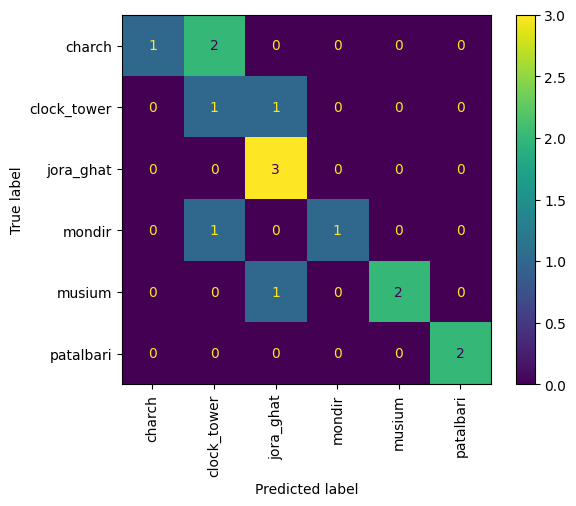

(66.66666666666667, np.float64(4.6910552978515625))

In [ ]:
# plot results
plot_classifier_results(
    train_loss22, valid_loss22, accy22, "Classifier model_A(ResNet18-sequential)"
)
classifier22.evaluate(disp_confusion_matrix=True)

### Higher epoches test 2


In [ ]:
model_B = models.resnet18(weights=None)
model_B = modify_last_layer(model_B, layer_type="sequential", pretrained=False)

# Instance 2 with different parameters
classifier22 = BuildingClassifier(
    model=model_B,
    optimizer=optim.Adam(model_B.parameters(), lr=0.0005),
    batch_size=16,
)

# change output_logging=True to print output of each iteration
train_loss22, valid_loss22, accy22 = classifier22.train(
    n_epochs=25, output_logging=True
)

convert from 512 to-> 256 to-> 6 output
Starting training with Learning Rate: 0.0005, Batch Size: 16, Epochs: 25, Device: cuda


  4%|▍         | 1/25 [00:12<05:00, 12.52s/it]

 Training loss: 13.0106 --Validation Loss: 89.9869 --Predict Accuracy: 13.33%


  8%|▊         | 2/25 [00:24<04:44, 12.38s/it]

 Training loss: 5.4127 --Validation Loss: 11.9832 --Predict Accuracy: 46.67%


 12%|█▏        | 3/25 [00:37<04:34, 12.49s/it]

 Training loss: 3.3329 --Validation Loss: 8.2439 --Predict Accuracy: 40.00%


 16%|█▌        | 4/25 [00:49<04:22, 12.52s/it]

 Training loss: 2.0122 --Validation Loss: 6.4327 --Predict Accuracy: 60.00%


 20%|██        | 5/25 [01:02<04:09, 12.47s/it]

 Training loss: 1.7825 --Validation Loss: 8.4378 --Predict Accuracy: 46.67%


 24%|██▍       | 6/25 [01:14<03:56, 12.45s/it]

 Training loss: 0.9499 --Validation Loss: 3.5352 --Predict Accuracy: 53.33%


 28%|██▊       | 7/25 [01:27<03:44, 12.46s/it]

 Training loss: 0.7296 --Validation Loss: 6.8509 --Predict Accuracy: 40.00%


 32%|███▏      | 8/25 [01:39<03:33, 12.54s/it]

 Training loss: 0.5801 --Validation Loss: 3.9610 --Predict Accuracy: 60.00%


 36%|███▌      | 9/25 [01:52<03:20, 12.55s/it]

 Training loss: 0.1629 --Validation Loss: 4.3154 --Predict Accuracy: 73.33%


 40%|████      | 10/25 [02:05<03:08, 12.57s/it]

 Training loss: 0.2480 --Validation Loss: 2.2179 --Predict Accuracy: 73.33%


 44%|████▍     | 11/25 [02:17<02:55, 12.56s/it]

 Training loss: 0.2507 --Validation Loss: 1.5498 --Predict Accuracy: 66.67%


 48%|████▊     | 12/25 [02:30<02:43, 12.55s/it]

 Training loss: 0.3033 --Validation Loss: 1.9798 --Predict Accuracy: 73.33%


 52%|█████▏    | 13/25 [02:42<02:30, 12.56s/it]

 Training loss: 0.2628 --Validation Loss: 1.8307 --Predict Accuracy: 73.33%


 56%|█████▌    | 14/25 [02:55<02:18, 12.57s/it]

 Training loss: 0.1541 --Validation Loss: 3.3808 --Predict Accuracy: 46.67%


 60%|██████    | 15/25 [03:08<02:05, 12.59s/it]

 Training loss: 0.1700 --Validation Loss: 2.5942 --Predict Accuracy: 60.00%


 64%|██████▍   | 16/25 [03:20<01:53, 12.59s/it]

 Training loss: 0.2307 --Validation Loss: 1.3449 --Predict Accuracy: 73.33%


 68%|██████▊   | 17/25 [03:33<01:40, 12.60s/it]

 Training loss: 0.1436 --Validation Loss: 1.5564 --Predict Accuracy: 66.67%


 72%|███████▏  | 18/25 [03:45<01:28, 12.60s/it]

 Training loss: 0.1980 --Validation Loss: 1.8024 --Predict Accuracy: 73.33%


 76%|███████▌  | 19/25 [03:58<01:15, 12.58s/it]

 Training loss: 0.1240 --Validation Loss: 1.5131 --Predict Accuracy: 66.67%


 80%|████████  | 20/25 [04:11<01:02, 12.60s/it]

 Training loss: 0.0575 --Validation Loss: 1.0172 --Predict Accuracy: 73.33%


 84%|████████▍ | 21/25 [04:23<00:50, 12.58s/it]

 Training loss: 0.0922 --Validation Loss: 0.4724 --Predict Accuracy: 86.67%


 88%|████████▊ | 22/25 [04:36<00:37, 12.60s/it]

 Training loss: 0.0924 --Validation Loss: 1.3699 --Predict Accuracy: 73.33%


 92%|█████████▏| 23/25 [04:48<00:25, 12.61s/it]

 Training loss: 0.3286 --Validation Loss: 2.1290 --Predict Accuracy: 73.33%


 96%|█████████▌| 24/25 [05:01<00:12, 12.57s/it]

 Training loss: 0.0609 --Validation Loss: 1.8176 --Predict Accuracy: 66.67%


100%|██████████| 25/25 [05:13<00:00, 12.55s/it]

 Training loss: 0.0955 --Validation Loss: 2.2294 --Predict Accuracy: 73.33%
Training done.....................


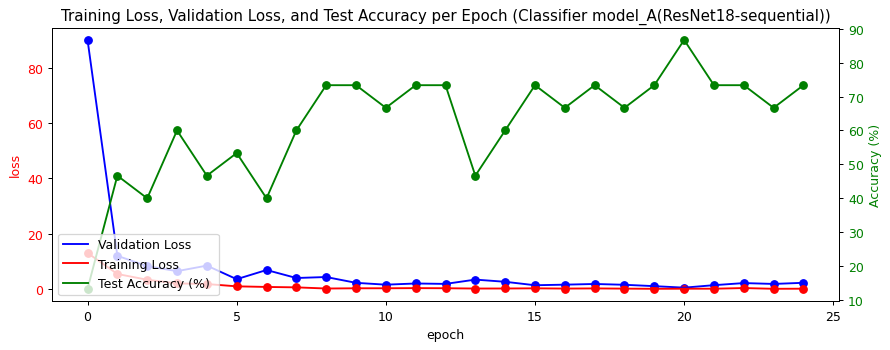

 --Validation loss:- 2.2293753623962402 --Testing....got-(11/15)-correctly-->>accuracy=(73.33%)


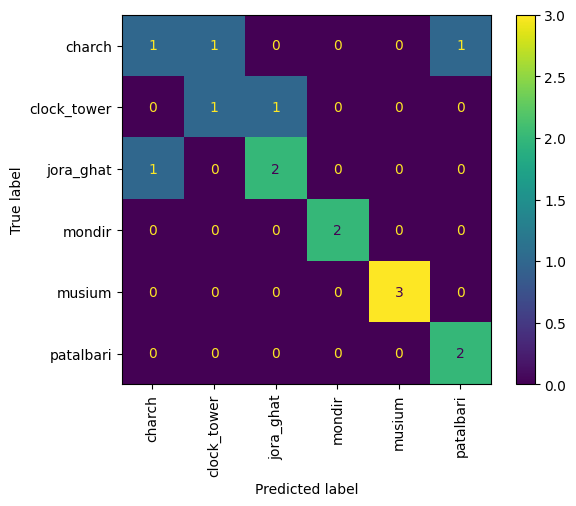

(73.33333333333333, np.float64(2.2293753623962402))

In [ ]:
# plot results
plot_classifier_results(
    train_loss22, valid_loss22, accy22, "Classifier model_A(ResNet18-sequential)"
)
classifier22.evaluate(disp_confusion_matrix=True)

### Higher epoches test 3


In [ ]:
model_C = models.resnet18(weights=None)
model_C = modify_last_layer(model_C, layer_type="sequential", pretrained=False)

# Instance 2 with different parameters
classifier22 = BuildingClassifier(
    model=model_C,
    optimizer=optim.Adam(model_C.parameters(), lr=0.0001),
    batch_size=32,
)

# change output_logging=True to print output of each iteration
train_loss22, valid_loss22, accy22 = classifier22.train(
    n_epochs=35, output_logging=True
)

convert from 512 to-> 256 to-> 6 output
Starting training with Learning Rate: 0.0001, Batch Size: 32, Epochs: 35, Device: cuda


  3%|▎         | 1/35 [00:12<06:53, 12.16s/it]

 Training loss: 10.9921 --Validation Loss: 7.0420 --Predict Accuracy: 13.33%


  6%|▌         | 2/35 [00:24<06:38, 12.08s/it]

 Training loss: 5.8226 --Validation Loss: 8.9403 --Predict Accuracy: 13.33%


  9%|▊         | 3/35 [00:36<06:22, 11.96s/it]

 Training loss: 4.0121 --Validation Loss: 10.0172 --Predict Accuracy: 20.00%


 11%|█▏        | 4/35 [00:47<06:08, 11.90s/it]

 Training loss: 3.3212 --Validation Loss: 9.5494 --Predict Accuracy: 26.67%


 14%|█▍        | 5/35 [00:59<05:59, 11.97s/it]

 Training loss: 2.0657 --Validation Loss: 7.1872 --Predict Accuracy: 46.67%


 17%|█▋        | 6/35 [01:12<05:50, 12.09s/it]

 Training loss: 1.7961 --Validation Loss: 9.2773 --Predict Accuracy: 40.00%


 20%|██        | 7/35 [01:24<05:39, 12.13s/it]

 Training loss: 1.1910 --Validation Loss: 8.0056 --Predict Accuracy: 33.33%


 23%|██▎       | 8/35 [01:37<05:31, 12.29s/it]

 Training loss: 0.8656 --Validation Loss: 6.9240 --Predict Accuracy: 40.00%


 26%|██▌       | 9/35 [01:49<05:18, 12.26s/it]

 Training loss: 1.0074 --Validation Loss: 7.3695 --Predict Accuracy: 46.67%


 29%|██▊       | 10/35 [02:01<05:07, 12.29s/it]

 Training loss: 0.9085 --Validation Loss: 5.5849 --Predict Accuracy: 66.67%


 31%|███▏      | 11/35 [02:13<04:54, 12.25s/it]

 Training loss: 0.5105 --Validation Loss: 5.5713 --Predict Accuracy: 53.33%


 34%|███▍      | 12/35 [02:26<04:41, 12.25s/it]

 Training loss: 0.4879 --Validation Loss: 7.6516 --Predict Accuracy: 53.33%


 37%|███▋      | 13/35 [02:38<04:29, 12.26s/it]

 Training loss: 0.3651 --Validation Loss: 6.4461 --Predict Accuracy: 53.33%


 40%|████      | 14/35 [02:50<04:16, 12.23s/it]

 Training loss: 0.3683 --Validation Loss: 5.9234 --Predict Accuracy: 53.33%


 43%|████▎     | 15/35 [03:02<04:03, 12.18s/it]

 Training loss: 0.3953 --Validation Loss: 6.8464 --Predict Accuracy: 60.00%


 46%|████▌     | 16/35 [03:15<03:54, 12.35s/it]

 Training loss: 0.2653 --Validation Loss: 6.9213 --Predict Accuracy: 53.33%


 49%|████▊     | 17/35 [03:27<03:39, 12.19s/it]

 Training loss: 0.5835 --Validation Loss: 12.1140 --Predict Accuracy: 60.00%


 51%|█████▏    | 18/35 [03:39<03:26, 12.14s/it]

 Training loss: 0.3339 --Validation Loss: 8.1467 --Predict Accuracy: 60.00%


 54%|█████▍    | 19/35 [03:51<03:13, 12.12s/it]

 Training loss: 0.1497 --Validation Loss: 8.3697 --Predict Accuracy: 66.67%


 57%|█████▋    | 20/35 [04:03<03:03, 12.24s/it]

 Training loss: 0.1949 --Validation Loss: 10.1483 --Predict Accuracy: 53.33%


 60%|██████    | 21/35 [04:15<02:51, 12.22s/it]

 Training loss: 0.3683 --Validation Loss: 8.5146 --Predict Accuracy: 53.33%


 63%|██████▎   | 22/35 [04:28<02:38, 12.23s/it]

 Training loss: 0.7119 --Validation Loss: 8.7316 --Predict Accuracy: 60.00%


 66%|██████▌   | 23/35 [04:40<02:26, 12.20s/it]

 Training loss: 0.4269 --Validation Loss: 7.2403 --Predict Accuracy: 73.33%


 69%|██████▊   | 24/35 [04:52<02:14, 12.20s/it]

 Training loss: 0.2314 --Validation Loss: 4.3299 --Predict Accuracy: 66.67%


 71%|███████▏  | 25/35 [05:04<02:02, 12.24s/it]

 Training loss: 0.1397 --Validation Loss: 5.2560 --Predict Accuracy: 60.00%


 74%|███████▍  | 26/35 [05:16<01:49, 12.19s/it]

 Training loss: 0.1949 --Validation Loss: 3.5711 --Predict Accuracy: 73.33%


 77%|███████▋  | 27/35 [05:29<01:37, 12.19s/it]

 Training loss: 0.1600 --Validation Loss: 8.8242 --Predict Accuracy: 53.33%


 80%|████████  | 28/35 [05:41<01:25, 12.17s/it]

 Training loss: 0.3570 --Validation Loss: 7.6893 --Predict Accuracy: 66.67%


 83%|████████▎ | 29/35 [05:53<01:12, 12.15s/it]

 Training loss: 0.2520 --Validation Loss: 10.6424 --Predict Accuracy: 60.00%


 86%|████████▌ | 30/35 [06:05<01:00, 12.02s/it]

 Training loss: 0.1835 --Validation Loss: 4.1559 --Predict Accuracy: 73.33%


 89%|████████▊ | 31/35 [06:16<00:47, 11.98s/it]

 Training loss: 0.1499 --Validation Loss: 4.0186 --Predict Accuracy: 66.67%


 91%|█████████▏| 32/35 [06:29<00:36, 12.09s/it]

 Training loss: 0.0691 --Validation Loss: 4.6172 --Predict Accuracy: 60.00%


 94%|█████████▍| 33/35 [06:41<00:24, 12.13s/it]

 Training loss: 0.0747 --Validation Loss: 8.2222 --Predict Accuracy: 66.67%


 97%|█████████▋| 34/35 [06:53<00:12, 12.15s/it]

 Training loss: 0.1000 --Validation Loss: 14.9781 --Predict Accuracy: 66.67%


100%|██████████| 35/35 [07:05<00:00, 12.17s/it]

 Training loss: 0.2018 --Validation Loss: 3.9697 --Predict Accuracy: 73.33%
Training done.....................


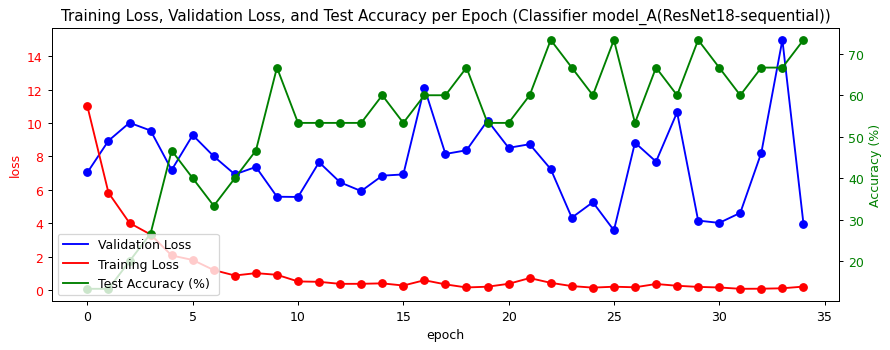

 --Validation loss:- 3.9696950912475586 --Testing....got-(11/15)-correctly-->>accuracy=(73.33%)


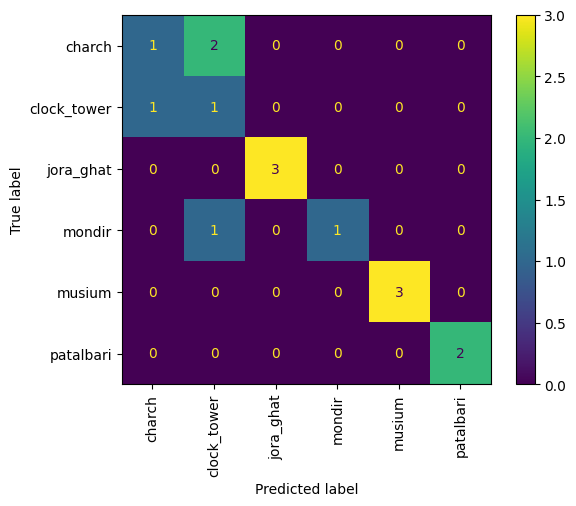

(73.33333333333333, np.float64(3.9696950912475586))

In [ ]:
# plot results
plot_classifier_results(
    train_loss22, valid_loss22, accy22, "Classifier model_A(ResNet18-sequential)"
)
classifier22.evaluate(disp_confusion_matrix=True)